In [1]:


import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp 




In [2]:

tfk = tf.keras 
tfkl = tfk.layers
tfpl = tfp.layers
tfd = tfp.distributions



In [3]:
# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')

# Generate synthetic data 

In [4]:
np.random.seed(1234)

def f(x):
    return 0.5 * np.sin(15 * x) + 0.5 * x

def noise(x, slope,):
    noise_std = np.maximum(0.0, x + 1.0 ) * slope 
    return np.random.normal(0, noise_std).astype(np.float64)



    
    

In [5]:
x_train = np.linspace(-1, 1, 500, dtype=np.float64).reshape(-1, 1)
y_train = f(x_train) + noise(x=x_train, slope=0.2, )


x_test = np.linspace(-1.5, 1.5, 200, dtype=np.float64).reshape(-1, 1)
y_test = f(x_test) + noise(x=x_test, slope=0.2, )




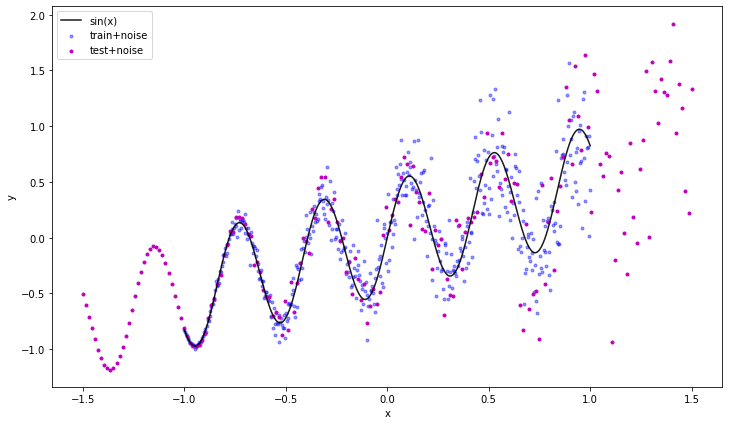

In [6]:


plt.figure(figsize=(12, 7))
plt.plot(x_train, f(x_train), color='k', marker='', alpha=0.9, label="sin(x)")
plt.scatter(x_train, y_train, color='b', marker='.', alpha=0.4, label="train+noise")
plt.scatter(x_test, y_test, color='m', marker='.', label="test+noise")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()




In [7]:
from sklearn.linear_model import LinearRegression


lr = LinearRegression().fit(x_train, y_train)

yhat_lr = lr.predict(x_test)


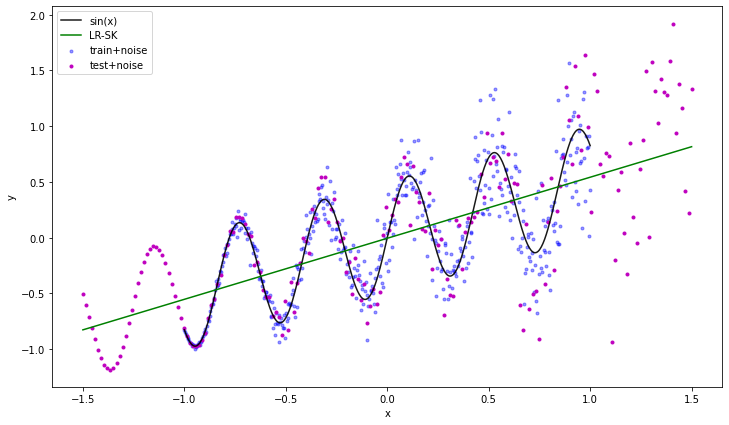

In [8]:


plt.figure(figsize=(12, 7))
plt.plot(x_train, f(x_train), color='k', marker='', alpha=0.9, label="sin(x)")
plt.scatter(x_train, y_train, color='b', marker='.', alpha=0.4, label="train+noise")
plt.scatter(x_test, y_test, color='m', marker='.', label="test+noise")
plt.plot(x_test, yhat_lr, color='g', label='LR-SK')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()



# Probabilistic regression


## modeling Aleatoric Uncertainty (Known Unknowns)

- learning a variants of data points (similar to MSE)



In [9]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)


In [10]:
# equivalent to LR from Sklearn

mdl_al = tfk.Sequential([
    tfkl.Dense(units=2), 
    tfkl.Dense(1+1), 
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], 
                                                 
                                                 scale=1e-3+tf.math.softplus(0.05*t[..., 1:]))),
])


mdl_al.compile(loss=negloglik, optimizer=tfk.optimizers.Adam(learning_rate=1e-3))

mdl_al.fit(x=x_train, y=y_train, epochs=1000, verbose=True)


yhat_al = mdl_al(x_test)





Epoch 1/1000
16/16 [==============================] - 0s 530us/step - loss: 0.7724
Epoch 2/1000
16/16 [==============================] - 0s 633us/step - loss: 0.7626
Epoch 3/1000
16/16 [==============================] - 0s 555us/step - loss: 0.7536
Epoch 4/1000
16/16 [==============================] - 0s 549us/step - loss: 0.7466
Epoch 5/1000
16/16 [==============================] - 0s 493us/step - loss: 0.7406
Epoch 6/1000
16/16 [==============================] - 0s 485us/step - loss: 0.7355
Epoch 7/1000
16/16 [==============================] - 0s 473us/step - loss: 0.7316
Epoch 8/1000
16/16 [==============================] - 0s 515us/step - loss: 0.7286
Epoch 9/1000
16/16 [==============================] - 0s 575us/step - loss: 0.7257
Epoch 10/1000
16/16 [==============================] - 0s 671us/step - loss: 0.7238
Epoch 11/1000
16/16 [==============================] - 0s 684us/step - loss: 0.7220
Epoch 12/1000
16/16 [==============================] - 0s 629us/step - loss: 0.7207
E

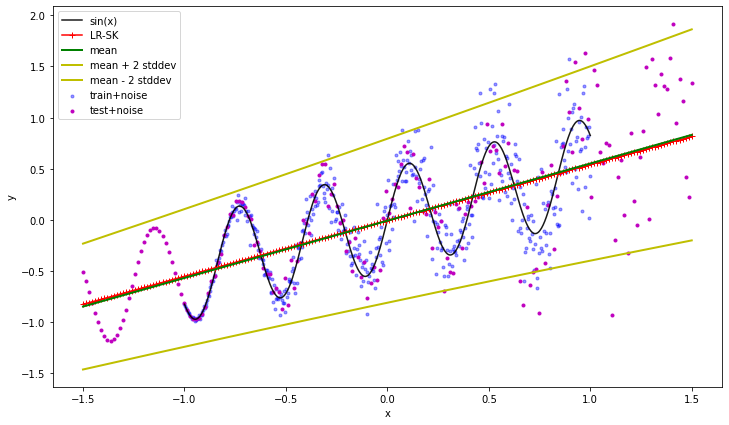

In [14]:
m_al = yhat_al.mean()
s_al = yhat_al.stddev()


plt.figure(figsize=(12, 7))
plt.plot(x_train, f(x_train), color='k', marker='', alpha=0.9, label="sin(x)")
plt.scatter(x_train, y_train, color='b', marker='.', alpha=0.4, label="train+noise")
plt.scatter(x_test, y_test, color='m', marker='.', label="test+noise")
plt.plot(x_test, yhat_lr, color='r', marker='+',  label='LR-SK')
plt.plot(x_test, m_al, color='g', marker='', linewidth=2, label=r'mean')
plt.plot(x_test, m_al + 2 * s_al, color='y', linewidth=2, label=r'mean + 2 stddev')
plt.plot(x_test, m_al - 2 * s_al, color='y', linewidth=2, label=r'mean - 2 stddev')



plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()



- red(green) line is the mean and yellow lines are stddevs. 



- Although the situation is better, now the question is: "how do we know that we have enough data?," is there "anything else we can do?", ... 

- Answer: of course, there is: why should we learn ONLY a set of weights, that is, why we should only learn the kernel and bias weight (when we use tfkl.Dense)?! We can learn a distribution over weights: by using tfp.DenseVariational instead: we learn a very large ensemble of weights called "Bayesian Weights." (thus, the weights will be random variables, RV)



## Epistemic and Aleatoric 


- We learn a very large ensemble of weights called "Bayesian Weights." (thus, the weights will be random variables, RV)




In [15]:
# Specify the surrogate posterior (posterior_mean_field) over 'keras.layers.Dense', i.e., 'kernel' and 'bias':
# to learn the distributions over weights: 
# both "means" and "stddevs" are tfd.Normal trainable.


def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))    
    return tfk.Sequential([
        tfpl.VariableLayer(shape=2*n, dtype=dtype),   # weights, i.e., kernel and bias
        tfpl.DistributionLambda(lambda t: tfd.Independent(
            distribution=tfd.Normal(loc=t[..., :n], # kernel weights
                                    scale=1e-5+tf.math.softplus(c+t[..., n:])),  # bias weight
            reinterpreted_batch_ndims=1,)),
    ])



# Specify the surrogate prior over the model's weights by learning the means of tfd.Normal
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tfk.Sequential([
        tfpl.VariableLayer(n, dtype=dtype),
        tfpl.DistributionLambda(lambda t: tfd.Independent(
            distribution=tfd.Normal(loc=t, scale=1.))),
    ])
    
    
    

In [16]:
mdl_ep_al = tfk.Sequential([
    
    tfpl.DenseVariational(units=(1+1), 
                          make_posterior_fn=posterior_mean_field, 
                          make_prior_fn=prior_trainable, 
                          kl_weight=1/x_train.shape[1]
                         ),
    
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], 
                                                 scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:]))),
])


mdl_ep_al.compile(loss=negloglik, optimizer=tfk.optimizers.Adam(learning_rate=1e-2))

mdl_ep_al.fit(x=x_train, y=y_train, epochs=3000, verbose=True, batch_size=32)



yhat_ep_al = mdl_ep_al(x_test)


Epoch 1/3000
16/16 [==============================] - 0s 546us/step - loss: -15.6917
Epoch 2/3000
16/16 [==============================] - 0s 531us/step - loss: -16.2461
Epoch 3/3000
16/16 [==============================] - 0s 528us/step - loss: -15.6702
Epoch 4/3000
16/16 [==============================] - 0s 497us/step - loss: -17.7744
Epoch 5/3000
16/16 [==============================] - 0s 505us/step - loss: -15.9406
Epoch 6/3000
16/16 [==============================] - 0s 505us/step - loss: -17.2642
Epoch 7/3000
16/16 [==============================] - 0s 519us/step - loss: -17.7777
Epoch 8/3000
16/16 [==============================] - 0s 515us/step - loss: -17.1732
Epoch 9/3000
16/16 [==============================] - 0s 517us/step - loss: -17.8795
Epoch 10/3000
16/16 [==============================] - 0s 522us/step - loss: -17.4893
Epoch 11/3000
16/16 [==============================] - 0s 535us/step - loss: -18.2783
Epoch 12/3000
16/16 [==============================] - 0s 489us

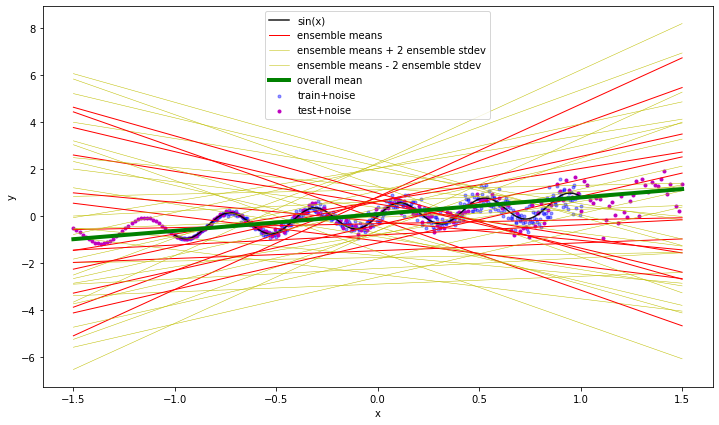

In [19]:


plt.figure(figsize=(12, 7))
plt.plot(x_train, f(x_train), color='k', marker='', alpha=0.9, label="sin(x)")
plt.scatter(x_train, y_train, color='b', marker='.', alpha=0.4, label="train+noise")
plt.scatter(x_test, y_test, color='m', marker='.', label="test+noise")
# plt.plot(x_test, yhat_lr, color='r', marker='+',  label='LR-SK')
# plt.plot(x_test, m_ep_al, color='g', marker='', linewidth=2, label=r'mean')
# plt.plot(x_test, m_ep_al + 2 * s_ep_al, color='y', linewidth=2, label=r'mean + 2 stddev')
# plt.plot(x_test, m_ep_al - 2 * s_ep_al, color='y', linewidth=2, label=r'mean - 2 stddev')

yhats_ep_al = [mdl_ep_al(x_test) for _ in range(100)]
avgm_ep_al = np.zeros_like(x_test[..., 0])
for i, yhat in enumerate(yhats_ep_al):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 15:
        plt.plot(x_test, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
        plt.plot(x_test, m + 2 * s, 'y', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None)
        plt.plot(x_test, m - 2 * s, 'y', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None)
    avgm_ep_al += m
plt.plot(x_test, avgm_ep_al/len(yhats_ep_al), 'g', label='overall mean', linewidth=4)




plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()




## Functional dependencies (VGP)

In [38]:
class RBFKernelFn(tfkl.Layer):
    
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        
        dtype = kwargs.get('dtype', None)
        
        self._amplitude = self.add_weight(
        initializer=tf.constant_initializer(0), 
        dtype=dtype, 
        name='amplitude')
        
        self._length_scale = self.add_weight(
        initializer=tf.constant_initializer(0), 
        dtype=dtype, 
        name="length_scale")
        
    def call(self, x):
        # never will be called: 
        # it just holds the data so that Keras will understand
        return x 
    
    @property
    def kernel(self):
        return tfp.math.psd_kernels.ExponentiatedQuadratic(
            amplitude=tf.nn.softplus(0.1 * self._amplitude),
            length_scale=tf.nn.softplus(5. * self._length_scale),
        )
        

In [53]:
x_range = [-1, +1]

# Build model_vgp.
num_inducing_points = 40

mdl_vgp = tfk.Sequential([
    tfkl.InputLayer(input_shape=[1,]),
    tfkl.Dense(1), 
    tfpl.VariationalGaussianProcess(num_inducing_points=num_inducing_points, 
                                    kernel_provider=RBFKernelFn(), 
                                    event_shape=[1,], 
                                    inducing_index_points_initializer=tf.constant_initializer(
                                        np.linspace(*x_range, num=num_inducing_points,
                                                    dtype=x_train.dtype)[..., np.newaxis]),
                                    unconstrained_observation_noise_variance_initializer=(
                                        tf.constant_initializer(np.array(0.54).astype(x_train.dtype))),
                                   ),
])



loss = lambda y, rv_y: rv_y.variational_loss(y, kl_weight=np.array(batch_size, x_train.dtype) / x_train.shape[0])

batch_size = 32
mdl_vgp.compile(loss=loss, optimizer=tfk.optimizers.Adam(1e-3))

hst_vgp = mdl_vgp.fit(x=x_train, y=y_train, epochs=3000, verbose=True, )


yhat_vgp = mdl_vgp(x_test)




/home/soroosh/tfGvenv/lib/python3.6/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:364: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


Epoch 1/3000
16/16 [==============================] - 2s 909us/step - loss: 58.8151
Epoch 2/3000
16/16 [==============================] - 0s 884us/step - loss: 55.7820
Epoch 3/3000
16/16 [==============================] - 0s 889us/step - loss: 51.3508
Epoch 4/3000
16/16 [==============================] - 0s 881us/step - loss: 49.4010
Epoch 5/3000
16/16 [==============================] - 0s 896us/step - loss: 48.8900
Epoch 6/3000
16/16 [==============================] - 0s 893us/step - loss: 48.7330
Epoch 7/3000
16/16 [==============================] - 0s 903us/step - loss: 48.4129
Epoch 8/3000
16/16 [==============================] - 0s 929us/step - loss: 48.1382
Epoch 9/3000
16/16 [==============================] - 0s 942us/step - loss: 47.9711
Epoch 10/3000
16/16 [==============================] - 0s 931us/step - loss: 47.7402
Epoch 11/3000
16/16 [==============================] - 0s 934us/step - loss: 47.5269
Epoch 12/3000
16/16 [==============================] - 0s 940us/step - los

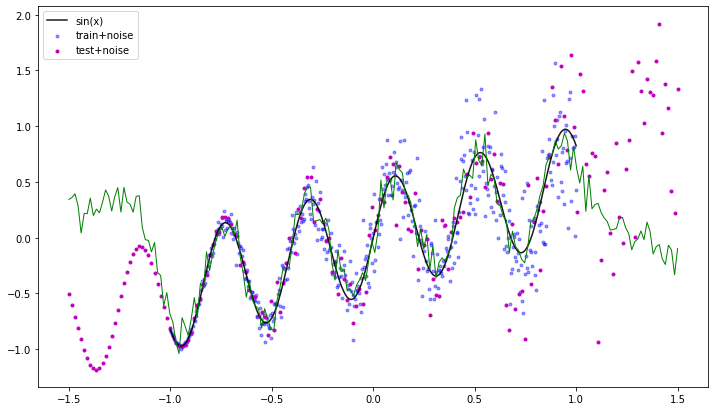

In [71]:


plt.figure(figsize=(12, 7))
plt.plot(x_train, f(x_train), color='k', marker='', alpha=0.9, label="sin(x)")
plt.scatter(x_train, y_train, color='b', marker='.', alpha=0.4, label="train+noise")
plt.scatter(x_test, y_test, color='m', marker='.', label="test+noise")
# plt.plot(x_test, yhat_lr, color='r', marker='+',  label='LR-SK')
# plt.plot(x_test, m_ep_al, color='g', marker='', linewidth=2, label=r'mean')
# plt.plot(x_test, m_ep_al + 2 * s_ep_al, color='y', linewidth=2, label=r'mean + 2 stddev')
# plt.plot(x_test, m_ep_al - 2 * s_ep_al, color='y', linewidth=2, label=r'mean - 2 stddev')

num_samples = 5
samples_vgp = []
for i in range(num_samples):
    samples_vgp.append(yhat_vgp.sample().numpy())

samples_vgp = np.asarray(samples_vgp)
samples_vgp = np.squeeze(samples_vgp)

plt.plot(x_test, samples_vgp.mean(axis=0), 'g', linewidth=1, label='ensemble means' if i == 0 else None);


plt.legend()
plt.show()


In [65]:
samples_vgp.shape



(5, 200, 1)

In [67]:
samples_vgp.shape



(5, 200)